In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from src import utils, plotting


pd.set_option('display.float_format', '{:,.2f}'.format)

In [2]:
ticker_1 = "GC=F"
ticker_2 = "HG=F"
period = "10y"
stock_1 = yf.Ticker(ticker_1.upper()).history(period=period).dropna()
stock_2 = yf.Ticker(ticker_2.upper()).history(period=period).dropna()

/Users/ivankyulev/Projects/Notebooks/.venv/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/Users/ivankyulev/Projects/Notebooks/.venv/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


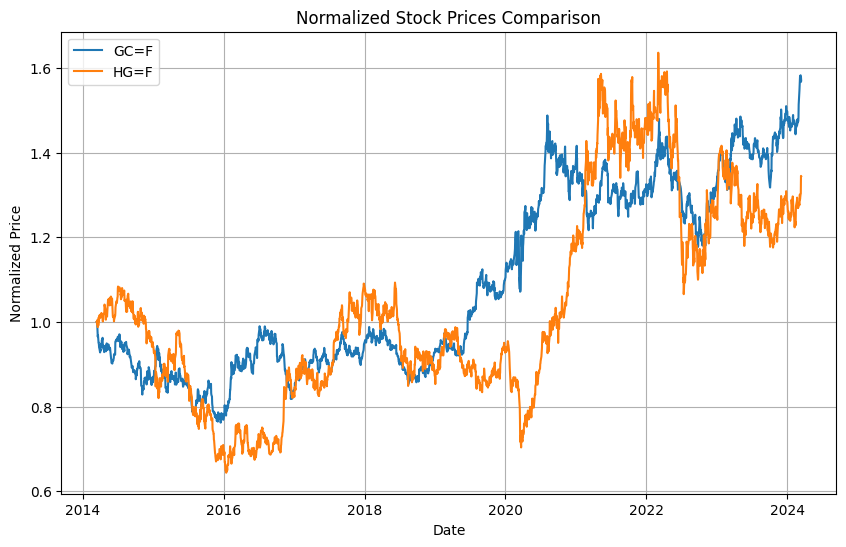

In [6]:
from src.plotting import plot_n_chart_comparison
plot_n_chart_comparison([(ticker_1, stock_1), (ticker_2, stock_2)], log_scale=False, sma_n=1)

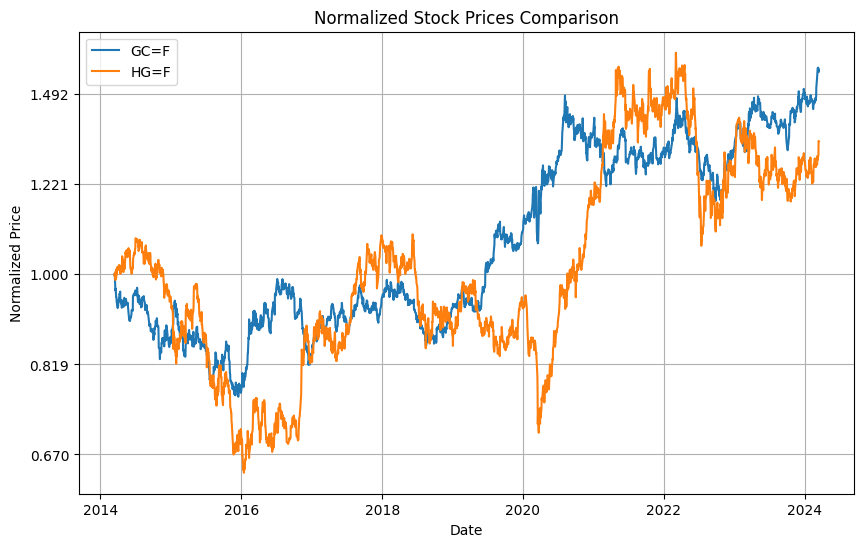

In [5]:
plot_n_chart_comparison([(ticker_1, stock_1), (ticker_2, stock_2)], log_scale=True)